In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [17]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
auto = automap_base()
# reflect the tables
auto.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
auto.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
measurement = auto.classes.measurement
station = auto.classes.station

In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [36]:
engine.execute('SELECT * FROM  Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [37]:
engine.execute('SELECT "date" FROM  Measurement LIMIT 5').fetchall()

[('2010-01-01',),
 ('2010-01-02',),
 ('2010-01-03',),
 ('2010-01-04',),
 ('2010-01-06',)]

In [38]:
current_date = session.query(measurement.date).all()

In [39]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

2016-08-23


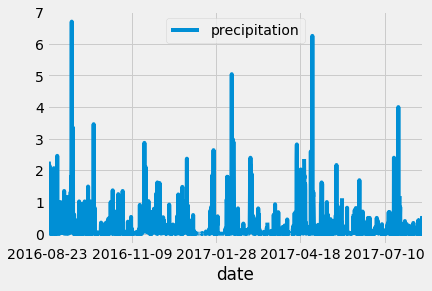

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
current_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
current_date = str(current_date)[2:-3]

year_back = str(eval(current_date[0:4])-1) + current_date[4:]
print(year_back)
# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_back).filter(measurement.date <= current_date).order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
year_prcp_df = pd.DataFrame(data=year_prcp)
year_prcp_df.set_index("date", inplace=True)
year_prcp_df.rename(columns={"prcp": "precipitation"}, inplace=True)
year_prcp_df.head()
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
year_prcp_df.plot()
plt.legend(loc=9)
plt.savefig("precipitation_analysis.png")
plt.show()

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(station.station))
station_count = stations[0]
station_count

(9)

In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.tobs))\
             .group_by(measurement.station).order_by(func.count(measurement.tobs).desc())

for station in active_stations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [48]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = active_stations[0][0]

stats = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == top_station)
                      
stats_list=list(stats)
print(stats_list)

[(54.0, 85.0, 71.66378066378067)]


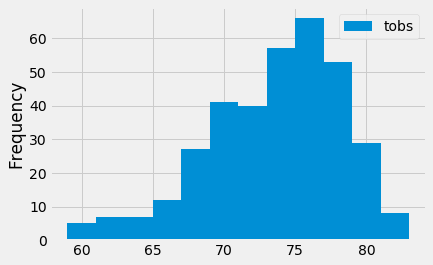

<Figure size 432x288 with 0 Axes>

In [51]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(measurement.tobs)\
.filter(measurement.date >= year_back)\
.filter(measurement.date <= current_date)\
.filter(measurement.station == top_station)\

tobs_list = []
for tob in tobs:
    tobs_list.append(tob[0])
    
fig = plt.figure()
plt.hist(tobs_list, bins=12 , label='tobs')
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.show()
plt.savefig("station_observation_analysis.png")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
